# **Facial Emotion Recognition Using CNN**


**Dataset used: fer2013**

* It contains facial images annotated with one of seven emotion labels: **anger, disgust, fear, happiness, sadness, surprise, and neutral.**

* **Size:** The FER2013 dataset contains 48x48 pixel grayscale images. It consists of **35,887** images in the training set, **3,589** images in the validation set, and **3,589** images in the test set, totaling **42,065** images.

* **Data Format:** The dataset is provided in **CSV (Comma-Separated Values)** format, where each row represents an image with pixel values and its associated emotion label

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving fer2013.csv.zip to fer2013.csv.zip


**Installing and importing all the necessary modules:**
* **NumPy:** It is being used for efficient data manipulation, preprocessing, and numerical computations
* **Pandas:** It is being used for data manipulation and analysis, providing data structures like DataFrames for working with structured data.
* **math:** It provides mathematical functions and constants for mathematical operations.
* **TensorFlow:** It is an open-source machine learning library developed by Google that offers tools for building and training deep learning models.
* **sklearn:** It provides a wide range of tools for data analysis, modeling, and machine learning tasks.
* **Scikit-plot:** It is a Python library that extends scikit-learn's functionality by providing additional tools for visualizing and evaluating machine learning results.

In [ ]:
!pip install scikit-plot

In [ ]:
import numpy as np
import pandas as pd
import math
import scikitplot
import seaborn as sns
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Unzipping dataset file using **zipfile** and **io** modules.

In [ ]:
import zipfile
import io
zip_file_name = 'fer2013.csv.zip'
with zipfile.ZipFile(io.BytesIO(uploaded[zip_file_name]), 'r') as zip_ref:
    zip_ref.extractall('extracted_data/')

**Data Loading & Exploration:**

Here, we read our dataset. The data from the CSV file is loaded into a Pandas DataFrame (df). Pandas DataFrames provide a tabular structure that allows us to organize, manipulate, and analyze data efficiently.

Once the data is loaded into the DataFrame, we can explore it to understand its structure, including columns for image pixel values and emotion labels. We can use Pandas functions to perform initial data analysis and visualization.

In [ ]:
df = pd.read_csv('extracted_data/fer2013.csv')

In [ ]:
df.shape

(35887, 3)

In [ ]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [ ]:
emotion_label_to_text = {0:'Anger', 1:'Disgust', 2:'Fear', 3:'Happiness', 4: 'Sadness', 5: 'Surprise', 6: 'Neutral'}

In [ ]:
df.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

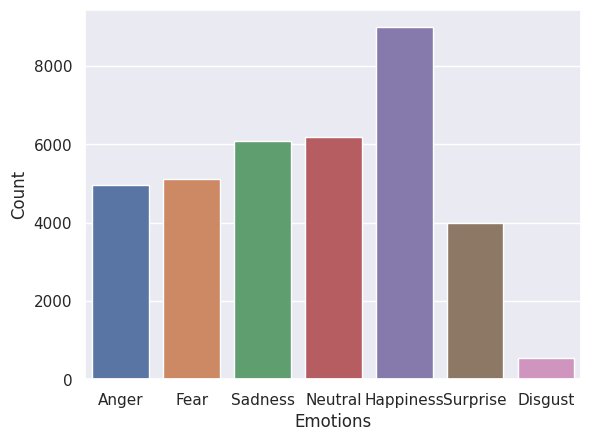

In [ ]:
df['emotion_text'] = df['emotion'].map(emotion_label_to_text)
sns.countplot(data=df, x='emotion_text')
pyplot.xlabel('Emotions')
pyplot.ylabel('Count')
pyplot.show()

Here, majority classes belong to Happy, Sad and Neutral. We are specifically interested in working with only three classes within the dataset, as these classes represent the majority of the data and are central to our analysis and modeling efforts in the context of facial emotion recognition using CNNs.

In [ ]:
math.sqrt(len(df.pixels[0].split(' ')))

48.0

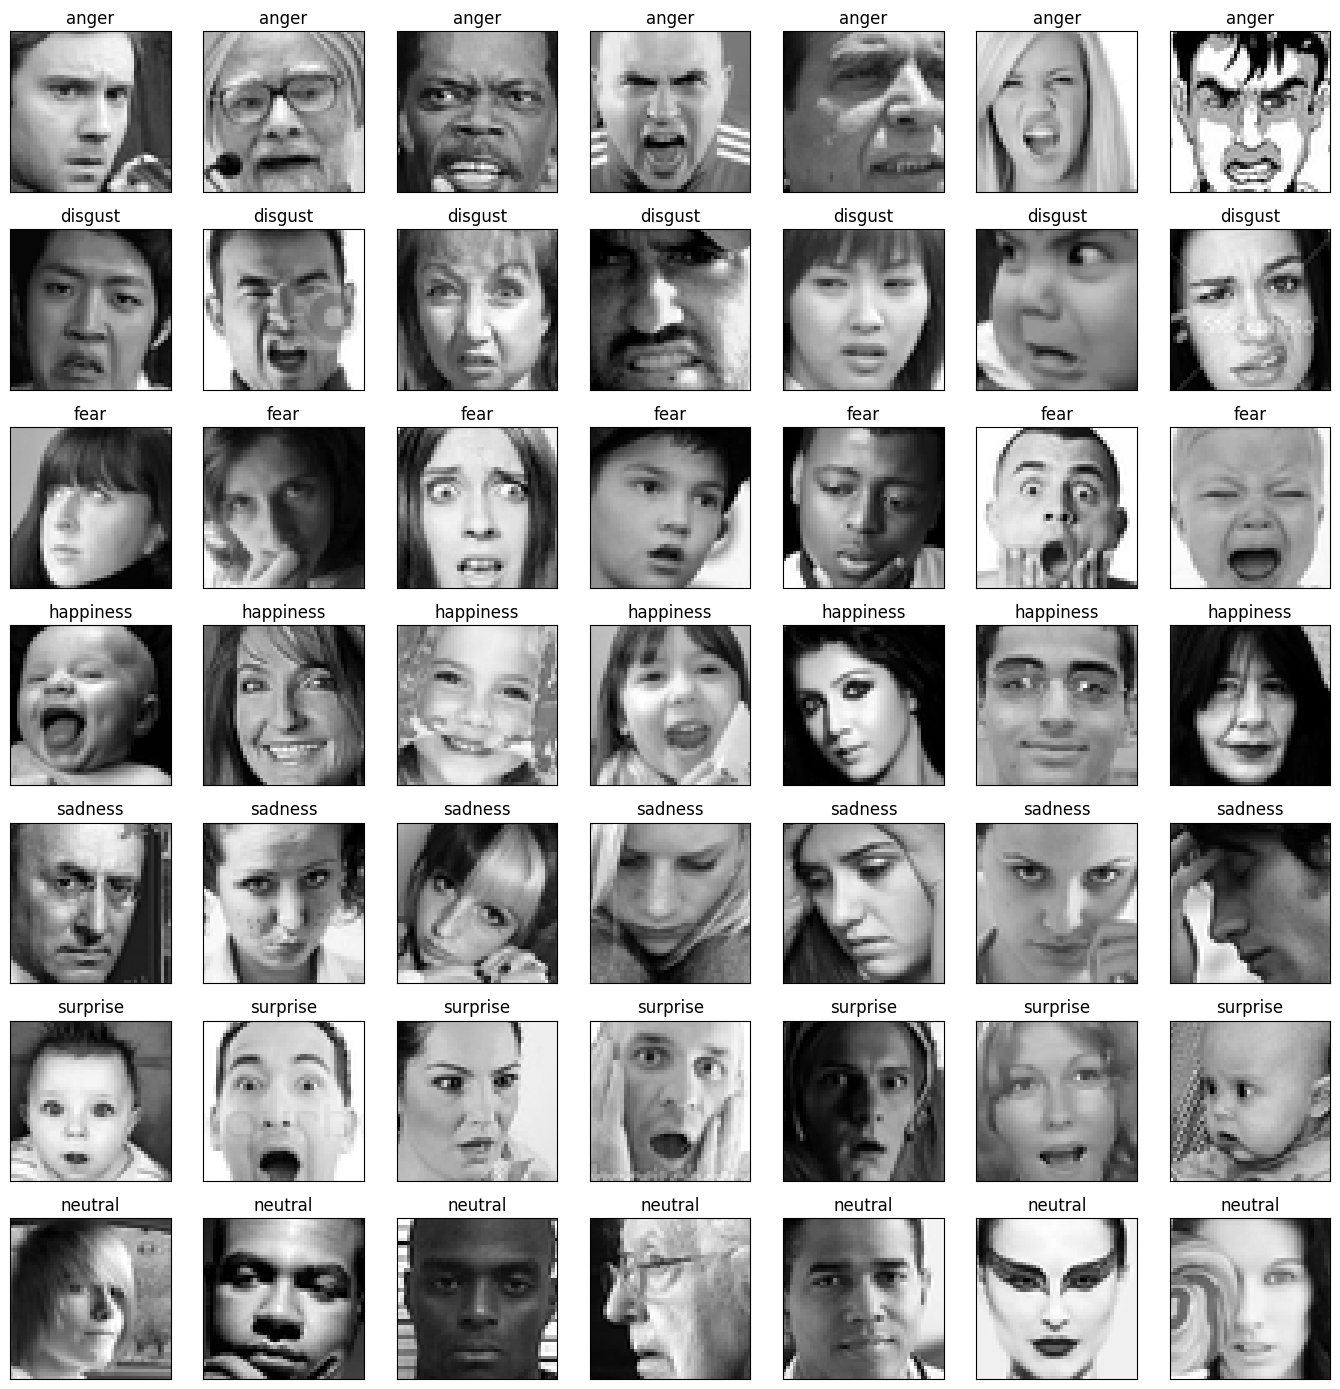

In [ ]:
fig = pyplot.figure(1, (14, 14))
k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

In [ ]:
INTERESTED_LABELS = [3, 4, 6]

In [ ]:
df = df[df.emotion.isin(INTERESTED_LABELS)]
df.shape

(21264, 3)

**Data Preprocessing:**

 Now, we are processing and preparing the image data for use in a Convolutional Neural Network (CNN) model:

* The pixel values of the images are extracted from the 'pixels' column of the DataFrame.
* The pixel values are split, converted into NumPy arrays, reshaped into the appropriate dimensions (assuming 48x48 pixel grayscale images), and converted to the 'float32' data type.
* Finally, these preprocessed image arrays are stacked together into a single NumPy array.

In [ ]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [ ]:
img_shape = img_array.shape
img_shape

(21264, 48, 48, 1)

Here, we are data label encoding and one-hot encoding, preparing the emotion labels for multi-class classification in a concise manner.

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = to_categorical(img_labels)
img_labels.shape


(21264, 3)

In [ ]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{3: 0, 4: 1, 6: 2}


**Data Splitting:**

Now, We split our dataset into two subsets:

* **Training Set (X_train, y_train):** This is being used to train our machine learning model, allowing it to learn patterns from the data.
* **Validation Set (X_valid, y_valid):** This is being used to evaluate the model's performance during training, adjust hyperparameters, and prevent overfitting. It also helps us estimate how well your model will perform on new, unseen data.

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.1, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((19137, 48, 48, 1), (2127, 48, 48, 1), (19137, 3), (2127, 3))

In [ ]:
del df
del img_array
del img_labels

In [ ]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

Normalizing results, as neural networks are very sensitive to unnormalized data.

In [ ]:
X_train = X_train / 255.
X_valid = X_valid / 255.

**Model Definition:**

Here, we define the architecture of the CNN model. This step involves specifying the layers, their configurations, and how they are connected. In the context of facial emotion recognition, this is a critical step, as the model needs to learn features from the input images to predict emotions accurately.

In [ ]:
def build_net(optim):
    net = Sequential(name='DCNN')
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))
    net.add(Flatten(name='flatten'))
    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    net.add(Dropout(0.6, name='dropout_4'))
    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )
    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )
    net.summary()
    return net

**Model Training Configuration:**

This is the step where we configure how the model will be trained. Here, we set up parameters like the loss function, optimizer, batch size, and the number of training epochs.

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)
callbacks = [
    early_stopping,
    lr_scheduler,
]

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

**Model Training:**

This step is responsible for training the model. It involves the following sub-steps:

* Setting the batch size and the number of training epochs (batch_size and epochs variables).
* Choosing one of the provided optimizers (Adam with a learning rate of 0.001 in this case).
* Creating a data generator (train_datagen.flow) to efficiently load and preprocess training data in batches.
* Training the model using the model.fit_generator method, which iteratively updates the model's weights for the specified number of epochs using mini-batches of training data.
* Monitoring the training process using callbacks, such as early stopping and learning rate adjustment (callbacks variable).

In [ ]:
batch_size = 32
epochs = 50
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]
model = build_net(optims[1])
history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

Model: "DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        1664      
                                                                 
 batchnorm_1 (BatchNormaliz  (None, 48, 48, 64)        256       
 ation)                                                          
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batchnorm_2 (BatchNormaliz  (None, 48, 48, 64)        256       
 ation)                                                          
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)        0      

<ipython-input-27-f7b4e3968352>:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


598/598 [==============================] - 36s 35ms/step - loss: 1.2478 - accuracy: 0.4115 - val_loss: 0.9530 - val_accuracy: 0.5444 - lr: 0.0010
Epoch 2/50
598/598 [==============================] - 20s 33ms/step - loss: 0.9949 - accuracy: 0.5022 - val_loss: 0.8246 - val_accuracy: 0.6126 - lr: 0.0010
Epoch 3/50
598/598 [==============================] - 20s 33ms/step - loss: 0.8740 - accuracy: 0.5799 - val_loss: 0.7649 - val_accuracy: 0.6620 - lr: 0.0010
Epoch 4/50
598/598 [==============================] - 19s 32ms/step - loss: 0.7826 - accuracy: 0.6316 - val_loss: 0.6785 - val_accuracy: 0.6935 - lr: 0.0010
Epoch 5/50
598/598 [==============================] - 20s 33ms/step - loss: 0.7391 - accuracy: 0.6601 - val_loss: 0.6954 - val_accuracy: 0.7005 - lr: 0.0010
Epoch 6/50
598/598 [==============================] - 19s 32ms/step - loss: 0.7149 - accuracy: 0.6798 - val_loss: 0.6745 - val_accuracy: 0.6977 - lr: 0.0010
Epoch 7/50
598/598 [==============================] - 20s 33ms/step -

**Model Saving:**

* `model.to_json() `converts the model's architecture to a JSON format representation. This includes the model's layers, configuration, and the connections between them.

* `with open("model.to_json", "w") as json_file:`  opens a file named `"model.to_json"` in write mode for saving the model architecture.

* `json_file.write(model_json)` writes the JSON representation of the model to the file `"model.to_json"`. This file will contain the model's architecture but not its weights.

* `model.save("model.h5")` saves the entire model, including its architecture and learned weights, to a file named `"model.h5"`. This is typically done using the HDF5 format, which can store both the model structure and the trained parameters.

In [ ]:
model_json = model.to_json()
with open("model.to_json", "w") as json_file:
    json_file.write(model_json)

model.save("model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**Visualization of Training History:**

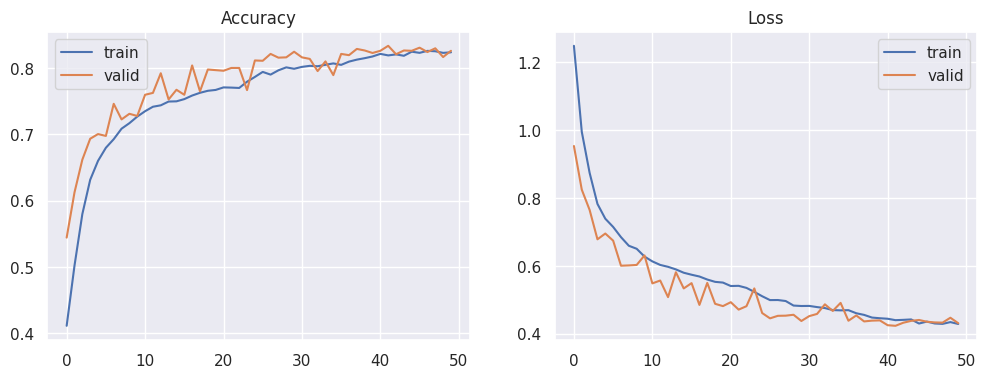

In [ ]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.legend(loc='best')

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.legend(loc='best')

pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()

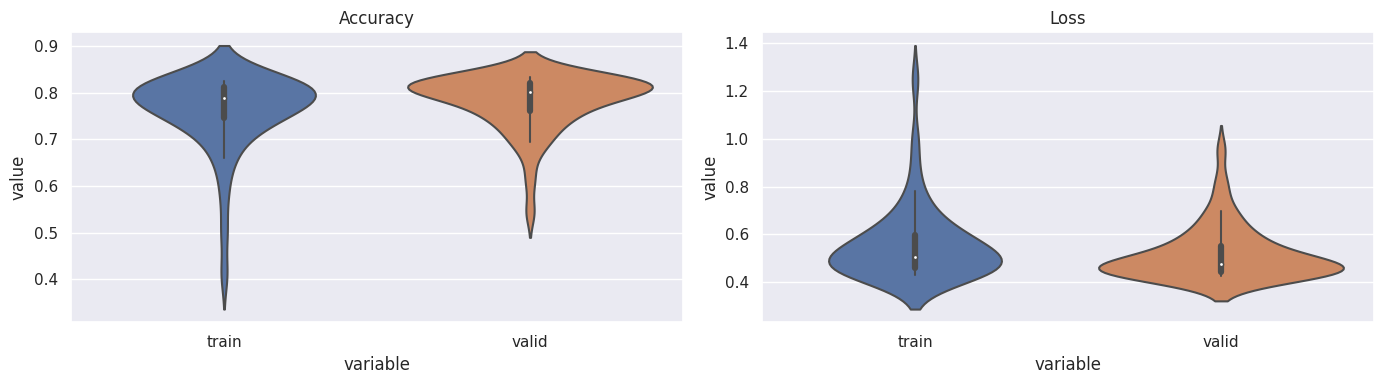

In [ ]:
df_accu = pd.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
df_loss = pd.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

fig = pyplot.figure(0, (14, 4))
ax = pyplot.subplot(1, 2, 1)
sns.violinplot(x="variable", y="value", data=pd.melt(df_accu), showfliers=False)
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.violinplot(x="variable", y="value", data=pd.melt(df_loss), showfliers=False)
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('performance_dist.png')
pyplot.show()

67/67 [==============================] - 1s 8ms/step
total wrong validation predictions: 370


              precision    recall  f1-score   support

           0       0.94      0.92      0.93       899
           1       0.78      0.75      0.77       608
           2       0.72      0.77      0.74       620

    accuracy                           0.83      2127
   macro avg       0.81      0.81      0.81      2127
weighted avg       0.83      0.83      0.83      2127



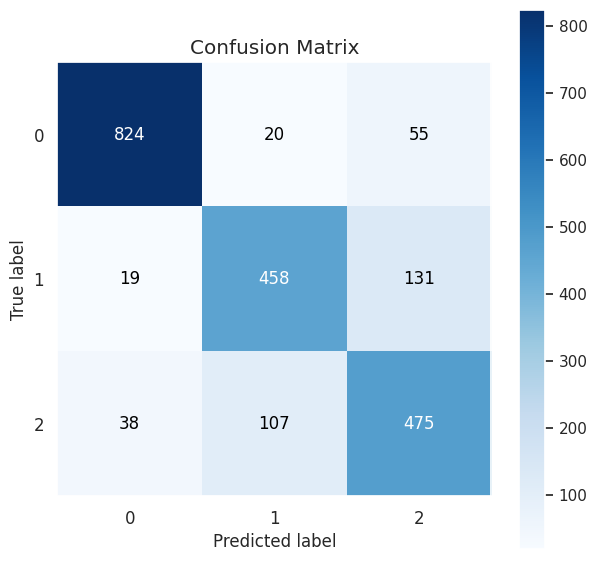

In [ ]:
yhat_valid_probs = model.predict(X_valid)
yhat_valid = np.argmax(yhat_valid_probs, axis=1)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, figsize=(7,7))
pyplot.savefig("confusion_matrix_dcnn.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))

**Model Evaluation:**

In this step, we are visualizing the model's predictions on a subset of validation data.
* We randomly select 9 images labeled as "sad" (random_sad_imgs) and 9 images labeled as "neutral" (random_neutral_imgs) from the validation set.
* For each selected image, we create two subplots in a figure:
* The left subplot displays the image itself using ax.imshow.
* The right subplot displays the true label and the predicted label for the emotion using ax.set_title.
* The true label is obtained from y_valid, and the predicted label is obtained by passing the image through the model and mapping the predicted class index to an emotion label using mapper.
* The result is a visualization of sample images along with their true and predicted labels for both "sad" and "neutral" emotions.

In [ ]:
mapper = {
    0: "happy",
    1: "sad",
    2: "neutral",
}

1/1 [==============================] - 0s 20ms/step


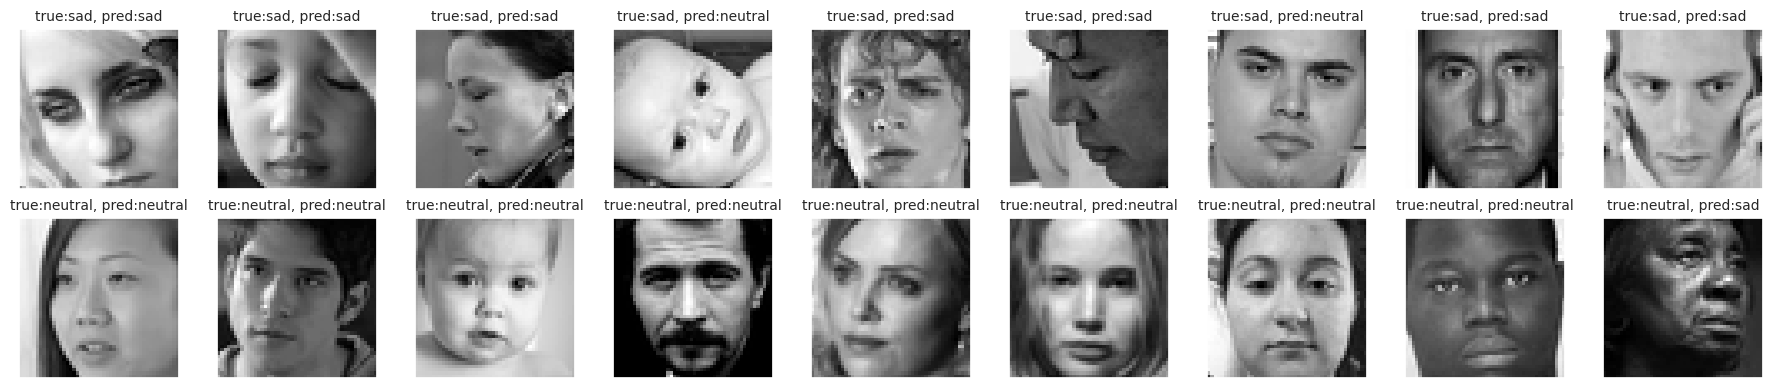

In [ ]:
font_size = 10
np.random.seed(2)
random_sad_imgs = np.random.choice(np.where(y_valid[:, 1] == 1)[0], size=9)
random_neutral_imgs = np.random.choice(np.where(y_valid[:, 2] == 1)[0], size=9)
fig = pyplot.figure(1, (18, 4))
for i, (sadidx, neuidx) in enumerate(zip(random_sad_imgs, random_neutral_imgs)):
    ax = pyplot.subplot(2, 9, i + 1)
    sample_img_sad = X_valid[sadidx, :, :, 0]
    ax.imshow(sample_img_sad, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    true_label_sad = "sad"
    predicted_label_sad = mapper[np.argmax(model.predict(sample_img_sad.reshape(1, 48, 48, 1)))]
    ax.set_title(f"true:{true_label_sad}, pred:{predicted_label_sad}", fontsize=font_size)
    ax = pyplot.subplot(2, 9, i + 10)
    sample_img_neutral = X_valid[neuidx, :, :, 0]
    ax.imshow(sample_img_neutral, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    true_label_neutral = "neutral"
    predicted_label_neutral = mapper[np.argmax(model.predict(sample_img_neutral.reshape(1, 48, 48, 1)))]
    ax.set_title(f"true:{true_label_neutral}, pred:{predicted_label_neutral}", fontsize=font_size)
pyplot.tight_layout()
pyplot.show()